# Light curve fitting - using temporal model
- Simulatenous (joint) fitting of several datasets.
- Does *not* use the light curve estimator
- Directly uses temporal models

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.time import Time
from gammapy.modeling.models import GaussianTemporalModel, ExpDecayTemporalModel, ConstantTemporalModel
from gammapy.modeling import Fit
from gammapy.datasets import Datasets, SpectrumDataset
from gammapy.modeling.models import PowerLawSpectralModel, SkyModel
from gammapy.maps import MapAxis

In [4]:
# Read the datasets previously produced
datasets = Datasets.read("./_datasets.yaml", "./_models.yaml")

# Use both temporal and spectral models to joint fit the datasets

- For simplicity, only the profiles used before

In [5]:
# First flare:
temporal1 = GaussianTemporalModel(t_ref = 53945.9 * u.day, sigma=10.0*u.min)
temporal1.parameters["t_ref"].frozen = False
temporal1.parameters["t_ref"].max = 53946.95
temporal1.parameters["t_ref"].min = 53945.85

spectral_model1 = PowerLawSpectralModel(
    index=3.4,
    amplitude=1e-11 * u.Unit("1 / (cm2 s TeV)"),
    reference=1 * u.TeV,
)
spectral_model1.parameters['index'].frozen = True 
#We keep the indices frozen for now - will thaw later
model1 = SkyModel(spectral_model=spectral_model1, temporal_model=temporal1, name="flare1")

In [6]:
temporal2 = GaussianTemporalModel(t_ref = 53946.07 * u.day, sigma=3.0*u.min)
temporal2.parameters["t_ref"].frozen = False
temporal2.parameters["t_ref"].max = 53946.10
temporal2.parameters["t_ref"].min = 53946.01

spectral_model2 = PowerLawSpectralModel(
    index=3.4,
    amplitude=1e-11 * u.Unit("1 / (cm2 s TeV)"),
    reference=1 * u.TeV,
)
spectral_model2.parameters['index'].frozen = True 

model2 = SkyModel(spectral_model=spectral_model2, temporal_model=temporal2, name="flare2")


In [7]:
#Attaching the models on the datasets to be fitted
datasets_fit = []
for ds in datasets[:16]:
    ds.models = model1
    datasets_fit.append(ds)
    
for ds in datasets[-30:-10]:
    ds.models = model2
    datasets_fit.append(ds)
datasets_fit=Datasets(datasets_fit)

In [8]:
%%time
fit = Fit(datasets_fit)
result = fit.run()

CPU times: user 1min 8s, sys: 517 ms, total: 1min 8s
Wall time: 1min 9s


In [9]:
result.success

True

In [10]:
L1 = result.total_stat
print(L1)

398.1628296854262


In [11]:
result.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str14,float64,float64,bool,float64
index,3.400e+00,,nan,nan,True,0.000e+00
amplitude,2.177e-10,cm-2 s-1 TeV-1,nan,nan,False,4.838e-12
reference,1.000e+00,TeV,nan,nan,True,0.000e+00
t_ref,5.395e+04,d,5.395e+04,5.395e+04,False,8.863e-04
sigma,3.021e-02,d,nan,nan,False,1.171e-03
index,3.400e+00,,nan,nan,True,0.000e+00
amplitude,6.446e-11,cm-2 s-1 TeV-1,nan,nan,False,2.281e-12
reference,1.000e+00,TeV,nan,nan,True,0.000e+00
t_ref,5.395e+04,d,5.395e+04,5.395e+04,False,2.391e-03


In [12]:
cnts = []
npreds = []
times = []
lvtm = []
exposure = []
for ds in datasets_fit:
    cnts.append(ds.counts.data.sum())
    npreds.append(ds.npred().data.sum())
    lvtm.append(ds.livetime.value)
    exposure.append(ds.exposure.data.sum())
    times.append((ds.gti.time_start + ds.gti.time_delta/2.0).mjd)

In [13]:
residuals = (np.array(cnts) - np.array(npreds))/np.array(npreds)

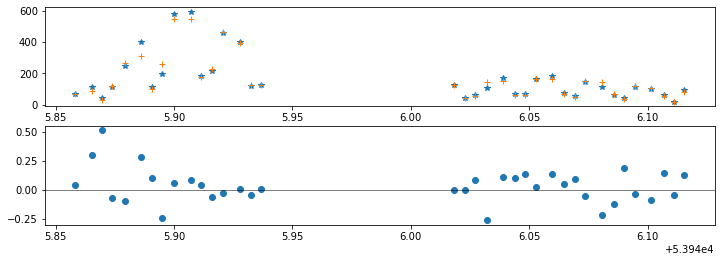

In [14]:
fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(times, cnts, "*")
ax1.plot(times, npreds, "+")

ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(times, residuals, "o")
ax2.axhline(0, color="black", lw=0.5)

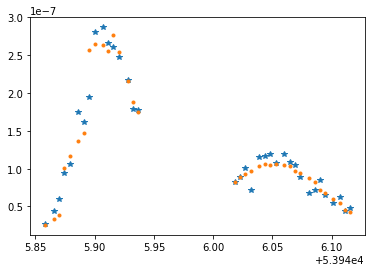

In [15]:
plt.plot(times, np.divide(cnts, exposure), "*")
plt.plot(times, np.divide(npreds, exposure), ".")

The fit works well. The power of this method is we can try to do fun things with it. Eg: Try to see if there are spectral changes between the flares

In [16]:
# Free the spectral parameter
model1.spectral_model.parameters['index'].frozen = False
model2.spectral_model.parameters['index'].frozen = False

In [17]:
%%time
fit = Fit(datasets_fit)
result = fit.run()

CPU times: user 36 s, sys: 249 ms, total: 36.2 s
Wall time: 36.6 s


In [18]:
result.success

True

In [19]:
L2 = result.total_stat
print(L2)

334.69759933674396


In [20]:
print(L1 - L2)

63.46523034868221


In [21]:
result.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str14,float64,float64,bool,float64
index,3.572e+00,,nan,nan,False,4.084e-02
amplitude,2.007e-10,cm-2 s-1 TeV-1,nan,nan,False,5.624e-12
reference,1.000e+00,TeV,nan,nan,True,0.000e+00
t_ref,5.395e+04,d,5.395e+04,5.395e+04,False,1.137e-03
sigma,3.151e-02,d,nan,nan,False,1.328e-03
index,3.766e+00,,nan,nan,False,5.070e-02
amplitude,5.259e-11,cm-2 s-1 TeV-1,nan,nan,False,2.119e-12
reference,1.000e+00,TeV,nan,nan,True,0.000e+00
t_ref,5.395e+04,d,5.395e+04,5.395e+04,False,2.515e-03


The indices in this case differ roughly by 2-sigma.

This can be applied for more general use cases
- spectral changes between flare and quiescent states
- quantifying variability while allowing for spectral changes
- fitting lightcurves between different instruments, telescopes